In [1]:
## Import data and packages ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse

In [2]:
## Upload data for error draws
draws = pd.read_csv('draw.out',sep='              ',header=None,engine='python')
draws = np.array(draws)

In [3]:
## Setup basic engine replacement model 
theta = np.array([0.3,0,4])
lam = 0.8
beta = 0.95

## p = .8 that bus advances to next state 
trans_matrix = sparse.diags([.2,.8],[0,1],shape=(11,11)).toarray()
trans_matrix[10,10]=1

def value_function0(x_t,params):
    val = -params[0]*x_t+-params[1]*x_t**2
    return val

def value_function1(params):
    val = -params[2]
    return val


In [4]:
## Define value function iteration algorithm
## Based on Choice Specific Value Function
def iteration(epsilon,params,maxiter,n_steps):
    values_matrix = np.full((n_steps,n_steps),-100.)    
    values_temp = np.zeros(n_steps)
    values = np.ones(n_steps)
    state = np.linspace(0,10,n_steps)

    diff = 1
    i = 0
    while diff > epsilon:
        
        no_change = value_function0(state,params)
        change = value_function1(params)
        
        values_temp = .5772 + np.log(np.exp(no_change+beta*values)+np.exp(change+beta*values[0]))
        values_temp = values_temp.dot(trans_matrix.T)
        
        diff = np.linalg.norm(values - values_temp)
        values = values_temp
        i+=1
#         print(i)
        if i == maxiter:
            break
            print("Max Iterations Reached")
        
    return values, i, diff
    
results = iteration(.00001,theta,500,11)
print(results[0])

[-5.93269495 -6.83084801 -7.4876776  -7.95206643 -8.27516537 -8.49964733
 -8.65668353 -8.76757443 -8.84631755 -8.90005197 -8.90984461]


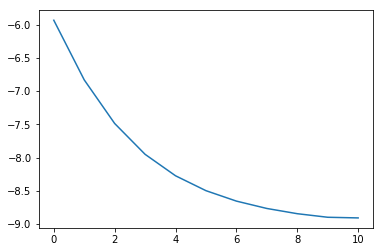

In [5]:
## plot values at each state
plt.plot(results[0])

[0.01798621 0.05484932 0.12755339 0.23476516 0.36016384 0.48465601
 0.59575037 0.68850419 0.76277273 0.82038958 0.86155815]


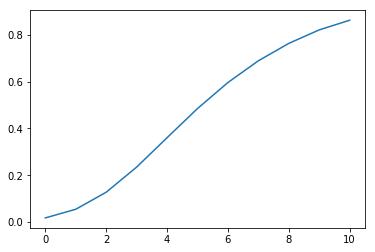

In [6]:
## Analytical Choice probability calculations
def choice_prob_calc(exp_vals,params):
    choice_prob_temp = np.zeros(11)
    v = exp_vals

    for i in range(11):
        state = i
        no_change = value_function0(state,params) + beta*(v[state])
        change = value_function1(params) + beta*(v[0])
        choice_prob_temp[i] = np.exp(change)/(np.exp(no_change)+np.exp(change))
    return choice_prob_temp
        
choice_prob = choice_prob_calc(results[0],theta)
print(choice_prob)
plt.plot(choice_prob)

In [7]:
## Simulation Results
def simulator(exp_val,params,seed):
    v = exp_val
    state = 0
    mat_temp = np.zeros((5000,4)) 

    np.random.seed(seed)

    draws_log = -np.log(-np.log(draws))

    for i in range(5000):
        no_change = value_function0(state,params) + beta*(v[state]) + draws_log[i,0]
        change = value_function1(params) + beta*(v[0]) + draws_log[i,1]
        mat_temp[i,0]=state
        mat_temp[i,1]=no_change
        mat_temp[i,2]=change
        if no_change <  change:
            mat_temp[i,3] = 1
            state = 0
        else:
            mat_temp[i,3] = 0

        bi = np.random.binomial(1,p=.8)
        if state < 10:
            state += bi
        else:
            state = 10
    return mat_temp

choice_matrix = simulator(results[0],theta,32)

In [8]:
## Calculate empirical choice probabilities from simulation
def f_choice_prob(mat,state):
    temp = mat[:,0]==state
    if temp.any():
        return mat[temp,3].mean()
    else:
        return 1
    
choice_prob_sim = np.zeros(11)    
for i in range(11):
    choice_prob_sim[i]=f_choice_prob(choice_matrix,i)
    print("State", i," average ",choice_prob_sim[i])

State 0  average  0.019762845849802372
State 1  average  0.055205047318611984
State 2  average  0.1231945624468989
State 3  average  0.24260958205912334
State 4  average  0.3302752293577982
State 5  average  0.5147058823529411
State 6  average  0.5443786982248521
State 7  average  0.6567164179104478
State 8  average  0.8
State 9  average  0.6666666666666666
State 10  average  1.0


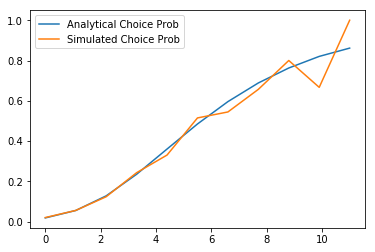

In [9]:
## plot empirical vs. analytical choice probablities
x = np.linspace(0,11,11)
plt.plot(x,choice_prob,label="Analytical Choice Prob")
plt.plot(x,choice_prob_sim,label="Simulated Choice Prob")
plt.legend()

In [10]:
## generate empirical cdf
def f_emp_cdf(mat,state):
    temp = mat[:,0] <= state
    count = temp.sum()
    return count
    
emp_cdf_sim = np.zeros(11)    
for i in range(11):
    emp_cdf_sim[i]=f_emp_cdf(choice_matrix,i)/5000
    print("State", i," average ",emp_cdf_sim[i])

State 0  average  0.0506
State 1  average  0.3042
State 2  average  0.5396
State 3  average  0.7358
State 4  average  0.8666
State 5  average  0.9482
State 6  average  0.982
State 7  average  0.9954
State 8  average  0.9994
State 9  average  1.0
State 10  average  1.0


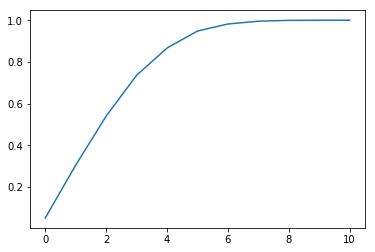

In [11]:
## plot empirical cdf
plt.plot(emp_cdf_sim)

In [13]:
## Define mle problem and estimate likelihood based on simulated results
def mle_estimator(params,epsilon,maxiter):
    
    print(params)
    vals = iteration(epsilon,params,500,11)
    
    choice_prob_temp = choice_prob_calc(vals[0],params)
    
    log_like = 0
    for i in range(5000):
        if i == 0:
            print(i)
        else:
            xt = int(choice_matrix[i,0])
            it = int(choice_matrix[i,3])
            xt_1 = int(choice_matrix[i-1,0])
            it_1 = int(choice_matrix[i-1,3])
            if it_1 == 1:
                if xt == 0:
                    p2 = .2
                else:
                    p2 = .8
            elif it_1 == 0:
                if xt == xt_1:
                    if xt == 10:
                        p2 = 1
                    else:
                        p2 = .2
                else:
                    p2 = .8
            if it == 1:
                p1 = choice_prob_temp[xt]
            else:
                p1 = 1 - choice_prob_temp[xt]
            log_like += np.log(p1*p2)
    
    return -log_like


In [14]:
## search parameter space to maximize log-likelihood
from scipy.optimize import fmin

mle_params1 = fmin(mle_estimator, theta, args=(.0001,500), xtol=0.0001, ftol=0.0001, maxiter=None)
print(mle_params1)

[0.3 0.  4. ]
0
[0.315 0.    4.   ]
0
[3.0e-01 2.5e-04 4.0e+00]
0
[0.3 0.  4.2]
0
[2.85000000e-01 1.66666667e-04 4.13333333e+00]
0
[3.07500000e-01 4.16666667e-05 4.03333333e+00]
0
[3.05000000e-01 1.94444444e-04 3.82222222e+00]
0
[3.01250000e-01 4.86111111e-05 4.10555556e+00]
0
[2.93333333e-01 1.57407407e-04 4.03703704e+00]
0
[2.94305556e-01 2.22993827e-04 3.91913580e+00]
0
[2.96041667e-01 1.79398148e-04 3.96574074e+00]
0
[ 2.92916667e-01 -2.54629630e-05  4.00185185e+00]
0
[ 2.89375000e-01 -1.63194444e-04  4.00277778e+00]
0
[ 2.99305556e-01 -5.47839506e-05  3.94135802e+00]
0
[2.94826389e-01 1.04359568e-04 4.01311728e+00]
0
[2.89189815e-01 1.72196502e-04 3.98713992e+00]
0
[ 2.88580247e-01 -1.20027435e-05  4.03566529e+00]
0
[2.94176312e-01 1.31547925e-04 3.98322188e+00]
0
[ 2.98756430e-01 -3.19001486e-05  4.01165409e+00]
0
[2.96364776e-01 1.91240141e-05 4.00552555e+00]
0
[2.97328318e-01 1.95483968e-04 3.99939129e+00]
0
[2.94019579e-01 2.97737697e-05 4.00123671e+00]
0
[2.94880723e-01 1.593

In [15]:
## use estimated parameters to find LR replacement probability
# Method 1: Simulation
EVs = iteration(.0001,mle_params1,500,11)
choice_prob2 = choice_prob_calc(EVs[0],mle_params1)
choice_matrix2 = simulator(EVs[0],mle_params1,32)
def f_state_prob(mat,state):
    temp = mat[:,0] == state
    count = temp.sum()
    return count
state_prob_sim = np.zeros(11)
for i in range(11):
    state_prob_sim[i]=f_state_prob(choice_matrix2,i)/5000
LR_rep_prob1 = state_prob_sim.T.dot(choice_prob2)
print(LR_rep_prob1)
print(choice_prob2)
print(state_prob_sim)

0.20978192441001373
[0.0179009  0.05487969 0.12722094 0.23260886 0.35447908 0.4745266
 0.58131514 0.67062019 0.74256835 0.79889135 0.83924866]
[0.051  0.2526 0.2326 0.1942 0.1312 0.083  0.0358 0.0146 0.0044 0.0006
 0.    ]


In [16]:
## use estimated parameters to find LR replacement probability
# Method 2: Analytical
EVs2 = iteration(.0001,mle_params1,500,11)
choice_prob2 = choice_prob_calc(EVs2[0],mle_params1)
markov_trans_matrix = np.zeros((11,11))
for i in range(11):
    chg_0 = choice_prob2[i]*.2
    chg_1 = choice_prob2[i]*.8
    nchg_0 = (1-choice_prob2[i])*.2
    nchg_1 = (1-choice_prob2[i])*.8
    if i != 10:
        markov_trans_matrix[i,0]+=chg_0
        markov_trans_matrix[i,1]+=chg_1
        markov_trans_matrix[i,i]+=nchg_0
        markov_trans_matrix[i,i+1]+=nchg_1
    else:
        markov_trans_matrix[i,0]+=chg_0
        markov_trans_matrix[i,1]+=chg_1
        markov_trans_matrix[i,i]+=nchg_0
        markov_trans_matrix[i,i]+=nchg_1
        
Q_temp = np.zeros(11)
Q_temp[0]=1
Q = np.ones(11)
Q_n = np.zeros(11)
while np.linalg.norm(Q-Q_n)>.001:
    Q=Q_temp
    Q_n=Q.dot(markov_trans_matrix)
    Q_temp=Q_n
    print(np.linalg.norm(Q-Q_n))
LR_rep_prob2 = np.sum(Q.T.dot(choice_prob2))
print("LR Replacement Probability:",LR_rep_prob2)
print(choice_prob2)
print(Q)

1.1313708498984762
0.771069901235947
0.5122364254700411
0.32422545619039184
0.19738042970476677
0.11815879850538097
0.06937745263274449
0.04093419425522924
0.025272444896325588
0.01567993328773743
0.009610775291223696
0.00611550108320224
0.003930942468217059
0.002444574474667785
0.0015413103907313398
0.0009971894476064496
LR Replacement Probability: 0.20746524901617358
[0.0179009  0.05487969 0.12722094 0.23260886 0.35447908 0.4745266
 0.58131514 0.67062019 0.74256835 0.79889135 0.83924866]
[5.17284955e-02 2.55226401e-01 2.34030746e-01 1.92517642e-01
 1.34949705e-01 7.77456335e-02 3.60370455e-02 1.31747601e-02
 3.68885904e-03 7.66072330e-04 1.34640146e-04]


In [17]:
## Policy exercise
# What is the effect of a 10% reduction on replacement costs on LR replacement probability
theta_policy = mle_params1
theta_policy[2] = mle_params1[2]*.9
EVs3 = iteration(.0001,theta_policy,500,11)
choice_prob3 = choice_prob_calc(EVs3[0],theta_policy)
markov_trans_matrix = np.zeros((11,11))
for i in range(11):
    chg_0 = choice_prob3[i]*.2
    chg_1 = choice_prob3[i]*.8
    nchg_0 = (1-choice_prob3[i])*.2
    nchg_1 = (1-choice_prob3[i])*.8
    if i != 10:
        markov_trans_matrix[i,0]+=chg_0
        markov_trans_matrix[i,1]+=chg_1
        markov_trans_matrix[i,i]+=nchg_0
        markov_trans_matrix[i,i+1]+=nchg_1
    else:
        markov_trans_matrix[i,0]+=chg_0
        markov_trans_matrix[i,1]+=chg_1
        markov_trans_matrix[i,i]+=nchg_0
        markov_trans_matrix[i,i]+=nchg_1
        
Q_temp = np.zeros(11)
Q_temp[0]=1
Q = np.ones(11)
Q_n = np.zeros(11)
while np.linalg.norm(Q-Q_n)>.001:
    Q=Q_temp
    Q_n=Q.dot(markov_trans_matrix)
    Q_temp=Q_n
    print(np.linalg.norm(Q-Q_n))
LR_rep_prob3 = np.sum(Q.T.dot(choice_prob3))
print("LR Replacement Probability:",LR_rep_prob3)
print(choice_prob3)
print(Q)

1.1313708498984762
0.7552963024640309
0.484775571278676
0.2934703149363889
0.1704211729029582
0.09704618247159814
0.05417295966821601
0.030729076310842644
0.018146940890706002
0.01062380564268358
0.006237982829623744
0.0038112321220407164
0.0022985250864207287
0.0013572263120283882
0.0008272555796061804
LR Replacement Probability: 0.22415433480131436
[0.02648442 0.0742138  0.15878706 0.27227959 0.39587659 0.51287249
 0.61437016 0.69794313 0.76463577 0.81659046 0.85393682]
[5.57505213e-02 2.73686994e-01 2.43616873e-01 1.91246605e-01
 1.26241128e-01 6.78550714e-02 2.90391267e-02 9.64228264e-03
 2.40628680e-03 4.42920973e-04 7.21904007e-05]


In [18]:
## Policy Effect
print("Policy Increases LR Replacement Probability by",(LR_rep_prob3-LR_rep_prob2)/LR_rep_prob2*100,"%")

Policy Increases LR Replacement Probability by 8.0442801212649 %
